In [1]:
import sys 
sys.path.append('/kaggle/input/hrstnet1/HRSTNet-main')

In [2]:

!pip install fvcore
!pip install monai
!pip install einops
!pip install nnunet
!pip install axial-attention
!pip install pyyaml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 796.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=f5e5de2a7a059570195a44615f1381dfde589b0d527938fc6e34acd495c98fc2
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=0aceb5a29b510686b1682f6dd0ec99206ce8a25645a05265b4635c3591acb83e
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 789.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install --use-pep517 mmcv-full==1.3.14

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.0/324.0 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | done
  Getting requirements to build wheel ... - done
  Installing backend dependencies ... - \ | done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for mmcv-full: filename=mmcv_full-1.3.14-py2.py3-none-any.whl size=471320 sha256=1ba4b7f526756900b583b137281572de9c2d40cbe95f46fe665ab6d4e5bb15da
  Stored in directory: /root/.cache/pip/wheels/30/93/c9/f9c60ddd8fde8e57dbbd7ae9dfbe0c657c48a64ddf9696466d
Successfully built mmcv-full


In [4]:
import torch
import torch.nn as nn
import copy
from seg.utils.register import MODEL_REGISTRY
from seg.models.vt_unet_utils import SwinTransformerSys3D


class VTUNet(nn.Module):
    def __init__(self, config, num_classes=3, zero_head=False, embed_dim=96, win_size=7):
        super(VTUNet, self).__init__()
        self.num_classes = num_classes
        self.zero_head = zero_head
        self.cfg = config
        self.embed_dim = embed_dim
        self.win_size = win_size
        self.win_size = (self.win_size, self.win_size, self.win_size)

        self.swin_unet = SwinTransformerSys3D(img_size=(config.INPUT.RAND_CROP.ROI.X,
                                                        config.INPUT.RAND_CROP.ROI.Y,
                                                        config.INPUT.RAND_CROP.ROI.Z),
                                              patch_size=(config.MODEL.SWIN.PATCH_SIZE,
                                                          config.MODEL.SWIN.PATCH_SIZE,
                                                          config.MODEL.SWIN.PATCH_SIZE),
                                              in_chans=config.MODEL.IN_CHANNEL,
                                              num_classes=self.num_classes,
                                              embed_dim=self.embed_dim,
                                              depths=config.MODEL.SWIN.DEPTH,
                                              depths_decoder=config.MODEL.VT_UNET.DEPTHS,
                                              num_heads=config.MODEL.SWIN.NUM_HEADS,
                                              window_size=self.win_size,
                                              mlp_ratio=config.MODEL.SWIN.MLP_RATE,
                                              qkv_bias=config.MODEL.SWIN.QKV_BIAS,
                                              drop_rate=config.MODEL.DROPOUT_RATE,
                                              attn_drop_rate=config.MODEL.ATTN_DROPOUT_RATE,
                                              drop_path_rate=config.MODEL.SWIN.DROP_PATH_RATE,
                                              patch_norm=True,
                                              use_checkpoint=config.MODEL.USE_CHECKPOINT,
                                              frozen_stages=config.MODEL.VT_UNET.FROZEN_STAGES,
                                              final_upsample=config.MODEL.VT_UNET.FINAL_UPSAMPLE)

    def forward(self, x):
        logits = self.swin_unet(x)
        return logits

    def load_from(self, config):
        pretrained_path = config.MODEL.PRETRAIN_CKPT
        if pretrained_path is not None:
            print("pretrained_path:{}".format(pretrained_path))
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            pretrained_dict = torch.load(pretrained_path, map_location=device)
            if "model" not in pretrained_dict:
                print("---start load pretrained modle by splitting---")
                pretrained_dict = {k[17:]: v for k, v in pretrained_dict.items()}
                for k in list(pretrained_dict.keys()):
                    if "output" in k:
                        print("delete key:{}".format(k))
                        del pretrained_dict[k]
                self.swin_unet.load_state_dict(pretrained_dict, strict=False)

                return
            pretrained_dict = pretrained_dict['model']
            print("---start load pretrained modle of swin encoder---")

            model_dict = self.swin_unet.state_dict()
            full_dict = copy.deepcopy(pretrained_dict)
            for k, v in pretrained_dict.items():
                if "layers." in k:
                    current_layer_num = 3 - int(k[7:8])
                    current_k = "layers_up." + str(current_layer_num) + k[8:]
                    full_dict.update({current_k: v})
            for k in list(full_dict.keys()):
                if k in model_dict:
                    if full_dict[k].shape != model_dict[k].shape:
                        print("delete:{};shape pretrain:{};shape model:{}".format(k, v.shape, model_dict[k].shape))
                        del full_dict[k]

            self.swin_unet.load_state_dict(full_dict, strict=False)
        else:
            print("none pretrain")


if "build_vt_unet" not in MODEL_REGISTRY:
    def build_vt_unet(cfg):
        return VTUNet(
            config=cfg,
            num_classes=cfg.MODEL.OUT_CHANNEL,
            embed_dim=cfg.MODEL.FEATURE_SIZE,
            win_size=cfg.MODEL.SWIN.WINDOW_SIZE
        )

2024-05-04 03:20:06.032625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 03:20:06.032750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 03:20:06.137339: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered




Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



In [5]:
import torch
from seg.utils.register import MODEL_REGISTRY
from typing import Sequence, Tuple, Union
from monai.networks.blocks import UnetOutBlock, UnetrBasicBlock, UnetrUpBlock
from monai.utils import ensure_tuple_rep
import numpy as np
from seg.models.swin.swin_transformer import SwinTransformer
import torch.nn as nn


class SwinUnet(torch.nn.Module):
    def __init__(self,
                 img_size: Union[Sequence[int], int],
                 in_channels: int,
                 out_channels: int,
                 depths: Sequence[int] = (2, 2, 2, 2),
                 num_heads: Sequence[int] = (3, 6, 12, 24),
                 feature_size: int = 24,
                 norm_name: Union[Tuple, str] = "instance",
                 drop_rate: float = 0.0,
                 attn_drop_rate: float = 0.0,
                 dropout_path_rate: float = 0.0,
                 normalize: bool = True,
                 use_checkpoint: bool = False,
                 spatial_dims: int = 3,
                 patch_size: int = 2,
                 window_size: int = 7,
                 cfgs=None
                 ):
        super().__init__()

        img_size = ensure_tuple_rep(img_size, spatial_dims)
        patch_size = ensure_tuple_rep(patch_size, spatial_dims)
        window_size = ensure_tuple_rep(window_size, spatial_dims)

        if not (spatial_dims == 2 or spatial_dims == 3):
            raise ValueError("spatial dimension should be 2 or 3.")

        for m, p in zip(img_size, patch_size):
            for i in range(5):
                if m % np.power(p, i + 1) != 0:
                    raise ValueError("input image size (img_size) should be divisible by stage-wise image resolution.")

        if not (0 <= drop_rate <= 1):
            raise ValueError("dropout rate should be between 0 and 1.")

        if not (0 <= attn_drop_rate <= 1):
            raise ValueError("attention dropout rate should be between 0 and 1.")

        if not (0 <= dropout_path_rate <= 1):
            raise ValueError("drop path rate should be between 0 and 1.")

        if feature_size % 12 != 0:
            raise ValueError("feature_size should be divisible by 12.")

        self.normalize = normalize

        self.cfgs = cfgs

        self.swinViT = SwinTransformer(
            in_chans=in_channels,
            embed_dim=feature_size,
            window_size=window_size,
            patch_size=patch_size,
            depths=depths,
            num_heads=num_heads,
            mlp_ratio=self.cfgs.MODEL.SWIN.MLP_RATE,
            qkv_bias=self.cfgs.MODEL.SWIN.QKV_BIAS,
            drop_rate=drop_rate,
            attn_drop_rate=attn_drop_rate,
            drop_path_rate=dropout_path_rate,
            norm_layer=nn.LayerNorm,
            use_checkpoint=use_checkpoint,
            spatial_dims=spatial_dims,
        )

        self.encoder1 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=in_channels,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder2 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder3 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=2 * feature_size,
            out_channels=2 * feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder4 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=4 * feature_size,
            out_channels=4 * feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder10 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=16 * feature_size,
            out_channels=16 * feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder5 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=16 * feature_size,
            out_channels=8 * feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder4 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 8,
            out_channels=feature_size * 4,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder3 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 4,
            out_channels=feature_size * 2,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )
        self.decoder2 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 2,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder1 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.out = UnetOutBlock(
            spatial_dims=spatial_dims, in_channels=feature_size, out_channels=out_channels
        )  # type: ignore

    def forward(self, x_in):
        hidden_states_out = self.swinViT(x_in, self.normalize)
        enc0 = self.encoder1(x_in)
        enc1 = self.encoder2(hidden_states_out[0])
        enc2 = self.encoder3(hidden_states_out[1])
        enc3 = self.encoder4(hidden_states_out[2])
        dec4 = self.encoder10(hidden_states_out[4])
        dec3 = self.decoder5(dec4, hidden_states_out[3])
        dec2 = self.decoder4(dec3, enc3)
        dec1 = self.decoder3(dec2, enc2)
        dec0 = self.decoder2(dec1, enc1)
        out = self.decoder1(dec0, enc0)
        logits = self.out(out)
        return logits

    def load_from(self, weights):
        with torch.no_grad():
            self.swinViT.patch_embed.proj.weight.copy_(weights["state_dict"]["module.patch_embed.proj.weight"])
            self.swinViT.patch_embed.proj.bias.copy_(weights["state_dict"]["module.patch_embed.proj.bias"])
            for bname, block in self.swinViT.layers1[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers1")
            self.swinViT.layers1[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers1.0.downsample.reduction.weight"]
            )
            self.swinViT.layers1[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers1.0.downsample.norm.weight"]
            )
            self.swinViT.layers1[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers1.0.downsample.norm.bias"]
            )
            for bname, block in self.swinViT.layers2[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers2")
            self.swinViT.layers2[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers2.0.downsample.reduction.weight"]
            )
            self.swinViT.layers2[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers2.0.downsample.norm.weight"]
            )
            self.swinViT.layers2[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers2.0.downsample.norm.bias"]
            )
            for bname, block in self.swinViT.layers3[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers3")
            self.swinViT.layers3[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers3.0.downsample.reduction.weight"]
            )
            self.swinViT.layers3[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers3.0.downsample.norm.weight"]
            )
            self.swinViT.layers3[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers3.0.downsample.norm.bias"]
            )
            for bname, block in self.swinViT.layers4[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers4")
            self.swinViT.layers4[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers4.0.downsample.reduction.weight"]
            )
            self.swinViT.layers4[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers4.0.downsample.norm.weight"]
            )
            self.swinViT.layers4[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers4.0.downsample.norm.bias"]
            )


# @MODEL_REGISTRY.register()
# def build_swin_unetr(cfg):
#     return SwinUnet(
#         img_size=(cfg.INPUT.RAND_CROP.ROI.X,
#                   cfg.INPUT.RAND_CROP.ROI.Y,
#                   cfg.INPUT.RAND_CROP.ROI.Z),
#         in_channels=cfg.MODEL.IN_CHANNEL,
#         out_channels=cfg.MODEL.OUT_CHANNEL,
#         depths=cfg.MODEL.SWIN.DEPTH,
#         num_heads=cfg.MODEL.SWIN.NUM_HEADS,
#         feature_size=cfg.MODEL.FEATURE_SIZE,
#         norm_name=cfg.MODEL.NORM,
#         drop_rate=cfg.MODEL.DROPOUT_RATE,
#         attn_drop_rate=cfg.MODEL.ATTN_DROPOUT_RATE,
#         dropout_path_rate=cfg.MODEL.SWIN.DROP_PATH_RATE,
#         use_checkpoint=cfg.MODEL.USE_CHECKPOINT,
#         cfgs=cfg,
#         window_size=cfg.MODEL.SWIN.WINDOW_SIZE,
#         patch_size=cfg.MODEL.SWIN.PATCH_SIZE
#     )

In [6]:
import yaml
from types import SimpleNamespace

# Load configuration from file
with open('/kaggle/input/hrstnet1/HRSTNet-main/configs/vt_unet_brats_2021_seg.yaml', 'r') as file:
    cfgs3_dict = yaml.safe_load(file)

# Convert the dictionary to a SimpleNamespace object
def convert_to_namespace(d):
    if isinstance(d, dict):
        return SimpleNamespace(**{k: convert_to_namespace(v) for k, v in d.items()})
    else:
        return d

cfgs3 = convert_to_namespace(cfgs3_dict)
print(cfgs3)

# Accessing attributes as object
print(cfgs3.MODEL.VT_UNET.DEPTHS)
print(cfgs3.MODEL.VT_UNET)



namespace(_BASE_='./dataset_path.yaml', MODEL=namespace(NAME='vt_unet', NORM='instance', IN_CHANNEL=4, OUT_CHANNEL=3, DROPOUT_RATE=0.0, ATTN_DROPOUT_RATE=0.0, WEIGHTS='', FEATURE_SIZE=96, USE_CHECKPOINT=False, SSL_PRETRAINED=False, SWIN=namespace(DEPTH=[2, 2, 2, 1], NUM_HEADS=[3, 6, 12, 24], SPATIAL_DIMS=3, WINDOW_SIZE=7, DROP_PATH_RATE=0.2, MLP_RATE=4.0, QKV_BIAS=True, PATCH_SIZE=4), VT_UNET=namespace(DEPTHS=[2, 2, 2, 1], FINAL_UPSAMPLE='expand_first', FROZEN_STAGES=-1)), INPUT=namespace(ORIENTATION='RSA', RAND_CROP=namespace(SAMPLES=1, POS=1, NEG=1, ROI=namespace(X=128, Y=128, Z=128)), RAND=namespace(FLIP_AXIS_PROB=0.2, ROTATE90_PROB=0.2, SCALE_INTENSITY_PROB=0.1, SHIFT_INTENSITY_PROB=0.1), FORMAT='NII'), DATASETS=namespace(JSON='dataset_0.json', DATA_DIR='', DATASET_TYPE='BraTS_2021', NAME='BraTS_2021_VT_UNET', TYPE='CACHE', CACHE=namespace(NUM=834, RATE=0.1), TEST_TYPE='validation'), DATALOADER=namespace(TRAIN_WORKERS=4, TEST_WORKERS=2), SOLVER=namespace(EPOCHS=300, BATCH_SIZE=1, S

In [7]:
import torch
model = VTUNet(config=cfgs3)
inputs = torch.rand(1, 4, 128, 128, 128)
outputs = model(inputs)
print(len(outputs))
print(outputs.shape)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---final upsample expand_first---
1
torch.Size([1, 3, 128, 128, 128])


In [8]:

from __future__ import annotations

import os
import shutil
import sys
import warnings
from collections.abc import Callable, Sequence
from pathlib import Path
from typing import Any

import numpy as np

from monai.apps.tcia import (
    download_tcia_series_instance,
    get_tcia_metadata,
    get_tcia_ref_uid,
    match_tcia_ref_uid_in_study,
)
# from monai.apps.utils import download_and_extract
from monai.config.type_definitions import PathLike
from monai.data import (
    CacheDataset,
    PydicomReader,
    load_decathlon_datalist,
    load_decathlon_properties,
    partition_dataset,
    select_cross_validation_folds,
)
from monai.transforms import LoadImaged, Randomizable
from monai.utils import ensure_tuple

def _basename(p: PathLike) -> str:
    """get the last part of the path (removing the trailing slash if it exists)"""
    sep = os.path.sep + (os.path.altsep or "") + "/ "
    return Path(f"{p}".rstrip(sep)).name

def extractall(
    filepath: PathLike,
    output_dir: PathLike = ".",
    hash_val: str | None = None,
    hash_type: str = "md5",
    file_type: str = "",
    has_base: bool = True,
) -> None:
    """
    Extract file to the output directory.
    Expected file types are: `zip`, `tar.gz` and `tar`.

    Args:
        filepath: the file path of compressed file.
        output_dir: target directory to save extracted files.
        hash_val: expected hash value to validate the compressed file.
            if None, skip hash validation.
        hash_type: 'md5' or 'sha1', defaults to 'md5'.
        file_type: string of file type for decompressing. Leave it empty to infer the type from the filepath basename.
        has_base: whether the extracted files have a base folder. This flag is used when checking if the existing
            folder is a result of `extractall`, if it is, the extraction is skipped. For example, if A.zip is unzipped
            to folder structure `A/*.png`, this flag should be True; if B.zip is unzipped to `*.png`, this flag should
            be False.

    Raises:
        RuntimeError: When the hash validation of the ``filepath`` compressed file fails.
        NotImplementedError: When the ``filepath`` file extension is not one of [zip", "tar.gz", "tar"].

    """
    if has_base:
        # the extracted files will be in this folder
        cache_dir = Path(output_dir, _basename(filepath).split(".")[0])
    else:
        cache_dir = Path(output_dir)
    if cache_dir.exists() and next(cache_dir.iterdir(), None) is not None:
        logger.info(f"Non-empty folder exists in {cache_dir}, skipped extracting.")
        return
    filepath = Path(filepath)
    if hash_val and not check_hash(filepath, hash_val, hash_type):
        raise RuntimeError(
            f"{hash_type} check of compressed file failed: " f"filepath={filepath}, expected {hash_type}={hash_val}."
        )
    print(f"Writing into directory: {output_dir}.")
    _file_type = file_type.lower().strip()
    print(filepath, _file_type)
    if filepath.name.endswith("zip") or _file_type == "zip":
        zip_file = zipfile.ZipFile(filepath)
        zip_file.extractall(output_dir)
        zip_file.close()
        return
    if filepath.name.endswith("tar") or filepath.name.endswith("tar.gz") or "tar" in _file_type:
        tar_file = tarfile.open(filepath)
        tar_file.extractall(output_dir)
        tar_file.close()
        return
    raise NotImplementedError(
        f'Unsupported file type, available options are: ["zip", "tar.gz", "tar"]. name={filepath} type={file_type}.'
    )


def download_and_extract(
    url: str,
    filepath: PathLike = "",
    output_dir: PathLike = ".",
    hash_val: str | None = None,
    hash_type: str = "md5",
    file_type: str = "",
    has_base: bool = True,
    progress: bool = True,
) -> None:
    """
    Download file from URL and extract it to the output directory.

    Args:
        url: source URL link to download file.
        filepath: the file path of the downloaded compressed file.
            use this option to keep the directly downloaded compressed file, to avoid further repeated downloads.
        output_dir: target directory to save extracted files.
            default is the current directory.
        hash_val: expected hash value to validate the downloaded file.
            if None, skip hash validation.
        hash_type: 'md5' or 'sha1', defaults to 'md5'.
        file_type: string of file type for decompressing. Leave it empty to infer the type from url's base file name.
        has_base: whether the extracted files have a base folder. This flag is used when checking if the existing
            folder is a result of `extractall`, if it is, the extraction is skipped. For example, if A.zip is unzipped
            to folder structure `A/*.png`, this flag should be True; if B.zip is unzipped to `*.png`, this flag should
            be False.
        progress: whether to display progress bar.
    """
    print()
    with tempfile.TemporaryDirectory() as tmp_dir:
        filename = filepath or Path(tmp_dir, _basename(url)).resolve()
#         shutil.copy("/kaggle/input/segresnet-data/BraTS-MEN-Train.zip", tmp_dir)
#         download_url(url=url, filepath=filename, hash_val=hash_val, hash_type=hash_type, progress=progress)
        extractall(filepath=filename, output_dir=output_dir, file_type=file_type, has_base=has_base)
        
class DecathlonDataset(Randomizable, CacheDataset):
    """
    The Dataset to automatically download the data of Medical Segmentation Decathlon challenge
    (http://medicaldecathlon.com/) and generate items for training, validation or test.
    It will also load these properties from the JSON config file of dataset. user can call `get_properties()`
    to get specified properties or all the properties loaded.
    It's based on :py:class:`monai.data.CacheDataset` to accelerate the training process.

    Args:
        root_dir: user's local directory for caching and loading the MSD datasets.
        task: which task to download and execute: one of list ("Task01_BrainTumour", "Task02_Heart",
            "Task03_Liver", "Task04_Hippocampus", "Task05_Prostate", "Task06_Lung", "Task07_Pancreas",
            "Task08_HepaticVessel", "Task09_Spleen", "Task10_Colon").
        section: expected data section, can be: `training`, `validation` or `test`.
        transform: transforms to execute operations on input data.
            for further usage, use `EnsureChannelFirstd` to convert the shape to [C, H, W, D].
        download: whether to download and extract the Decathlon from resource link, default is False.
            if expected file already exists, skip downloading even set it to True.
            user can manually copy tar file or dataset folder to the root directory.
        val_frac: percentage of validation fraction in the whole dataset, default is 0.2.
        seed: random seed to randomly shuffle the datalist before splitting into training and validation, default is 0.
            note to set same seed for `training` and `validation` sections.
        cache_num: number of items to be cached. Default is `sys.maxsize`.
            will take the minimum of (cache_num, data_length x cache_rate, data_length).
        cache_rate: percentage of cached data in total, default is 1.0 (cache all).
            will take the minimum of (cache_num, data_length x cache_rate, data_length).
        num_workers: the number of worker threads if computing cache in the initialization.
            If num_workers is None then the number returned by os.cpu_count() is used.
            If a value less than 1 is specified, 1 will be used instead.
        progress: whether to display a progress bar when downloading dataset and computing the transform cache content.
        copy_cache: whether to `deepcopy` the cache content before applying the random transforms,
            default to `True`. if the random transforms don't modify the cached content
            (for example, randomly crop from the cached image and deepcopy the crop region)
            or if every cache item is only used once in a `multi-processing` environment,
            may set `copy=False` for better performance.
        as_contiguous: whether to convert the cached NumPy array or PyTorch tensor to be contiguous.
            it may help improve the performance of following logic.
        runtime_cache: whether to compute cache at the runtime, default to `False` to prepare
            the cache content at initialization. See: :py:class:`monai.data.CacheDataset`.

    Raises:
        ValueError: When ``root_dir`` is not a directory.
        ValueError: When ``task`` is not one of ["Task01_BrainTumour", "Task02_Heart",
            "Task03_Liver", "Task04_Hippocampus", "Task05_Prostate", "Task06_Lung", "Task07_Pancreas",
            "Task08_HepaticVessel", "Task09_Spleen", "Task10_Colon"].
        RuntimeError: When ``dataset_dir`` doesn't exist and downloading is not selected (``download=False``).

    Example::

        transform = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                EnsureChannelFirstd(keys=["image", "label"]),
                ScaleIntensityd(keys="image"),
                ToTensord(keys=["image", "label"]),
            ]
        )

        val_data = DecathlonDataset(
            root_dir="./", task="Task09_Spleen", transform=transform, section="validation", seed=12345, download=True
        )

        print(val_data[0]["image"], val_data[0]["label"])

    """

    resource = {
        "Task01_BrainTumour": "/kaggle/input/segresnet-data/BraTS-MEN-Train",
        "Task02_Heart": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task02_Heart.tar",
        "Task03_Liver": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task03_Liver.tar",
        "Task04_Hippocampus": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task04_Hippocampus.tar",
        "Task05_Prostate": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task05_Prostate.tar",
        "Task06_Lung": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task06_Lung.tar",
        "Task07_Pancreas": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task07_Pancreas.tar",
        "Task08_HepaticVessel": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task08_HepaticVessel.tar",
        "Task09_Spleen": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar",
        "Task10_Colon": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task10_Colon.tar",
    }
    md5 = {
        "Task01_BrainTumour": "240a19d752f0d9e9101544901065d872",
        "Task02_Heart": "06ee59366e1e5124267b774dbd654057",
        "Task03_Liver": "a90ec6c4aa7f6a3d087205e23d4e6397",
        "Task04_Hippocampus": "9d24dba78a72977dbd1d2e110310f31b",
        "Task05_Prostate": "35138f08b1efaef89d7424d2bcc928db",
        "Task06_Lung": "8afd997733c7fc0432f71255ba4e52dc",
        "Task07_Pancreas": "4f7080cfca169fa8066d17ce6eb061e4",
        "Task08_HepaticVessel": "641d79e80ec66453921d997fbf12a29c",
        "Task09_Spleen": "410d4a301da4e5b2f6f86ec3ddba524e",
        "Task10_Colon": "bad7a188931dc2f6acf72b08eb6202d0",
    }

    def __init__(
        self,
        root_dir: PathLike,
        task: str,
        section: str,
        transform: Sequence[Callable] | Callable = (),
        download: bool = False,
        seed: int = 0,
        val_frac: float = 0.2,
        cache_num: int = sys.maxsize,
        cache_rate: float = 1.0,
        num_workers: int = 1,
        progress: bool = True,
        copy_cache: bool = True,
        as_contiguous: bool = True,
        runtime_cache: bool = False,
    ) -> None:
        root_dir = Path(root_dir)
        if not root_dir.is_dir():
            raise ValueError("Root directory root_dir must be a directory.")
        self.section = section
        self.val_frac = val_frac
        self.set_random_state(seed=seed)
        if task not in self.resource:
            raise ValueError(f"Unsupported task: {task}, available options are: {list(self.resource.keys())}.")
        dataset_dir = root_dir / task
#         tarfile_name = f"{dataset_dir}.tar"
#         if download:
#             download_and_extract(
#                 url=self.resource[task],
#                 filepath=tarfile_name,
#                 output_dir=root_dir,
#                 hash_val=self.md5[task],
#                 hash_type="md5",
#                 progress=progress,
#             )

#         if not dataset_dir.exists():
#             raise RuntimeError(
#                 f"Cannot find dataset directory: {dataset_dir}, please use download=True to download it."
#             )
#         dataset_dir = "/kaggle/input/meningits-part1/brain-men-train1"
        self.indices: np.ndarray = np.array([])
        data = self._generate_data_list("/kaggle/input/json-data")
        # as `release` key has typo in Task04 config file, ignore it.
        property_keys = [
            "name",
            "description",
            "reference",
            "licence",
            "tensorImageSize",
            "modality",
            "labels",
            "numTraining",
            "numTest",
        ]
#         self._properties = load_decathlon_properties("/kaggle/input/segres-json/dataset.json", property_keys)
        if transform == ():
            transform = LoadImaged(["image", "label"])
        CacheDataset.__init__(
            self,
            data=data,
            transform=transform,
            cache_num=cache_num,
            cache_rate=cache_rate,
            num_workers=num_workers,
            progress=progress,
            copy_cache=copy_cache,
            as_contiguous=as_contiguous,
            runtime_cache=runtime_cache,
        )


# [docs]
    def get_indices(self) -> np.ndarray:
        """
        Get the indices of datalist used in this dataset.

        """
        return self.indices




# [docs]
    def randomize(self, data: np.ndarray) -> None:
        self.R.shuffle(data)




# [docs]
    def get_properties(self, keys: Sequence[str] | str | None = None) -> dict:
        """
        Get the loaded properties of dataset with specified keys.
        If no keys specified, return all the loaded properties.

        """
        if keys is None:
            return self._properties
        if self._properties is not None:
            return {key: self._properties[key] for key in ensure_tuple(keys)}
        return {}



    def _generate_data_list(self, dataset_dir: PathLike) -> list[dict]:
        # the types of the item in data list should be compatible with the dataloader
        dataset_dir = Path(dataset_dir) 
        section = "training" if self.section in ["training", "validation", "test"] else "test"
        datalist = load_decathlon_datalist("/kaggle/input/json-data/metastasis_dataset.json", True, section)
#         datalist2 = load_decathlon_datalist("/kaggle/input/segres-json/dataset.json", True, section)
#         datalist = datalist.append(datalist2)
#         print(datalist[898])
#         print(".............................................................................")
        return self._split_datalist(datalist)

    def _split_datalist(self, datalist: list[dict]) -> list[dict]:
#         if self.section == "test":
#             return datalist
        length = len(datalist)
        indices = np.arange(length)
        self.randomize(indices)

        
        val_length = int(length * self.val_frac)
        
        if self.section == "training":
            self.indices = indices[val_length:]
        elif self.section == "validation":
            self.indices = indices[:100]
        else:
            self.indices = indices[100:246]
#         print(self.indices)
        return [datalist[i] for i in self.indices]

In [9]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
# from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
# from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism

import torch

print_config()

MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.1.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.0.post2
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.11.4
Pillow version: 9.5.0
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.2
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.39.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/i

In [10]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpxgppchzb


In [11]:
set_determinism(seed=0)

In [12]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

In [13]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 128], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

In [14]:
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

test_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="test",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4)

print(len(train_ds), len(val_ds), len(test_ds))


190 100 137


image shape: torch.Size([4, 240, 240, 155])


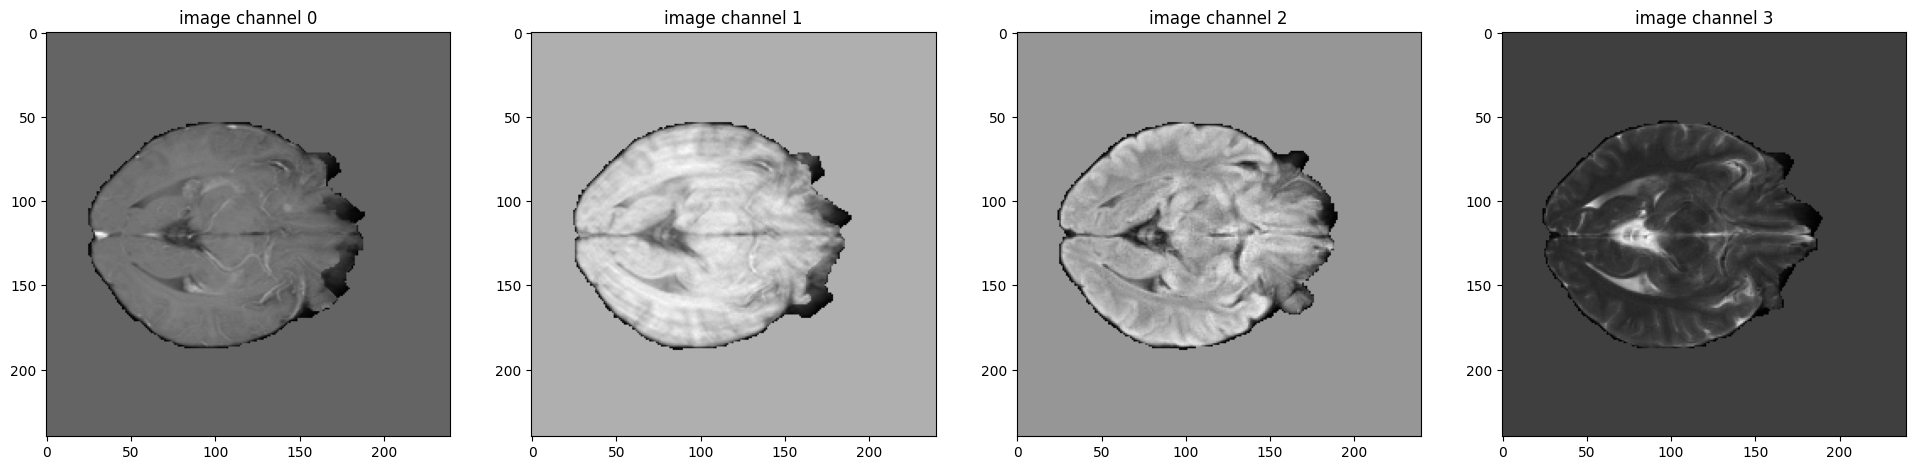

label shape: torch.Size([3, 240, 240, 155])


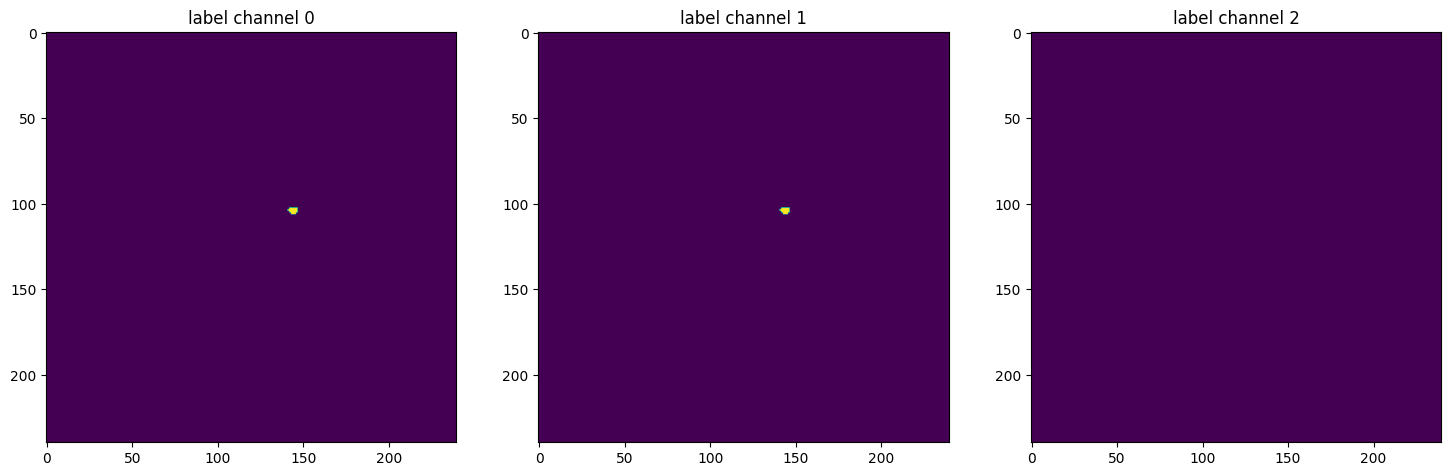

In [15]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()

In [16]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from torchvision.transforms import Compose
from monai.transforms import Compose, Activations, AsDiscrete


max_epochs = 60
val_interval = 1
VAL_AMP = True
device=torch.device("cuda:0")
model = VTUNet(config=cfgs3).to(device)
inputs = torch.rand(1, 4, 128, 128, 128).to(device)
image_size = 128
outputs = model(inputs)
print(outputs.shape)
# print(model)
model.load_state_dict(torch.load("/kaggle/input/dispersioncheckp/best_metric_model (20).pth"))

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(128, 128, 128),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

---final upsample expand_first---
torch.Size([1, 3, 128, 128, 128])


In [17]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
val_epoch_loss_values = []
metric_values = []
train_metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []
import time

total_start = time.time()

for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    epoch_metric = 0
    val_epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        outputs = [post_trans(i) for i in decollate_batch(outputs)]
        dice_metric(y_pred=outputs, y=labels)
        train_metric = dice_metric.aggregate().item()
        epoch_metric += train_metric
        
#         dice_metric_batch(y_pred=outputs, y=labels)
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", current mean dice: {train_metric:.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_metric /= step
    epoch_loss_values.append(epoch_loss)
    train_metric_values.append(epoch_metric)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}"
          f", average metric: {epoch_metric:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_step = 0
            for val_data in val_loader:
                val_step += 1
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                loss = loss_function(val_outputs, val_labels)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)
                val_epoch_loss += loss.item()
                
            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join("/kaggle/working/", "best_metric_model.pth"),
                )
                print("saved new best metric model")
            chk_file_name = "epoch_" + str(epoch) + "_model.pth"    
            torch.save(
                    model.state_dict(),
                    os.path.join("/kaggle/working/", chk_file_name),
                )
            val_epoch_loss /= val_step
            val_epoch_loss_values.append(val_epoch_loss)
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f", val_loss: {val_epoch_loss:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/60
1/190, train_loss: 0.1912, current mean dice: 0.7739, step time: 2.8667
2/190, train_loss: 0.1514, current mean dice: 0.7943, step time: 1.0600
3/190, train_loss: 0.2391, current mean dice: 0.7768, step time: 0.6399
4/190, train_loss: 0.4161, current mean dice: 0.7112, step time: 0.6258
5/190, train_loss: 0.9974, current mean dice: 0.5690, step time: 0.6936
6/190, train_loss: 0.7940, current mean dice: 0.4896, step time: 0.7106
7/190, train_loss: 0.2087, current mean dice: 0.5272, step time: 0.6063
8/190, train_loss: 0.2110, current mean dice: 0.5552, step time: 0.6303
9/190, train_loss: 0.0695, current mean dice: 0.5951, step time: 0.6285
10/190, train_loss: 0.9940, current mean dice: 0.5356, step time: 0.8866
11/190, train_loss: 0.0966, current mean dice: 0.5670, step time: 0.6855
12/190, train_loss: 0.1159, current mean dice: 0.5912, step time: 0.6240
13/190, train_loss: 0.4763, current mean dice: 0.5830, step time: 0.6025
14/190, train_loss: 1.0000, current me

In [18]:
print(len(val_epoch_loss_values), val_epoch_loss_values)
print(len(epoch_loss_values), epoch_loss_values)
print(len(train_metric_values), train_metric_values)
print(len(metric_values), metric_values)

60 [0.39612249203026295, 0.45638156998902557, 0.3934115720540285, 0.3941467410698533, 0.39647167108952996, 0.38396341729909184, 0.4155397863686085, 0.4268844137340784, 0.393405333943665, 0.4000002496317029, 0.38871261954307557, 0.3813748969510198, 0.400444212667644, 0.3796688849106431, 0.3875570360198617, 0.3911750725284219, 0.37586289014667273, 0.373288627974689, 0.392276407815516, 0.40205898180603983, 0.37945356603711844, 0.38059140864759683, 0.3668580299988389, 0.3646695433184505, 0.3802929611504078, 0.37193012945353987, 0.3789313841611147, 0.361147687509656, 0.3780522482469678, 0.369470699839294, 0.3525491882860661, 0.3568127489462495, 0.3585108468309045, 0.3529743842035532, 0.3550721863284707, 0.3554099978134036, 0.35678209591656923, 0.35915889345109464, 0.3646415673941374, 0.3539655406028032, 0.3627192977815866, 0.3563530819118023, 0.3603197793662548, 0.35948582738637924, 0.35165670786052944, 0.3473248563706875, 0.3470580806210637, 0.35186778239905836, 0.34897131711244583, 0.3513

In [19]:
import shutil

source_path = "/kaggle/input/metrics-loss/SegResNet_data.csv"
destination_path = "/kaggle/working/SegResNet_data.csv"

# Copy the file
shutil.copy(source_path, destination_path)

print(f"File '{source_path}' copied to '{destination_path}'.")


File '/kaggle/input/metrics-loss/SegResNet_data.csv' copied to '/kaggle/working/SegResNet_data.csv'.


In [20]:
import csv

# Your lists of data
# list1 = [1, 2, 3, 4, 5]
# list2 = ['a', 'b', 'c', 'd', 'e']
# list3 = [10, 20, 30, 40, 50]
# list4 = ['apple', 'banana', 'cherry', 'date', 'elderberry']

# CSV file path
csv_file_path = '/kaggle/working/SegResNet_data.csv'

# Column names
fieldnames = ['epoch_loss_values', 'train_metric_values', 'val_epoch_loss_values', 'metric_values']

# Writing lists to a CSV file with specific column names
with open(csv_file_path, 'a', newline='') as csvfile:  # Change 'w' to 'a' for append mode
    # Create a CSV writer object with DictWriter
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Write the lists to the specified columns
    for i in range(len(epoch_loss_values)):
        csv_writer.writerow({
            'epoch_loss_values': epoch_loss_values[i],
            'train_metric_values': train_metric_values[i],
            'val_epoch_loss_values': val_epoch_loss_values[i],
            'metric_values': metric_values[i]
        })



In [21]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.6488 at epoch: 60, total time: 35418.594220638275.


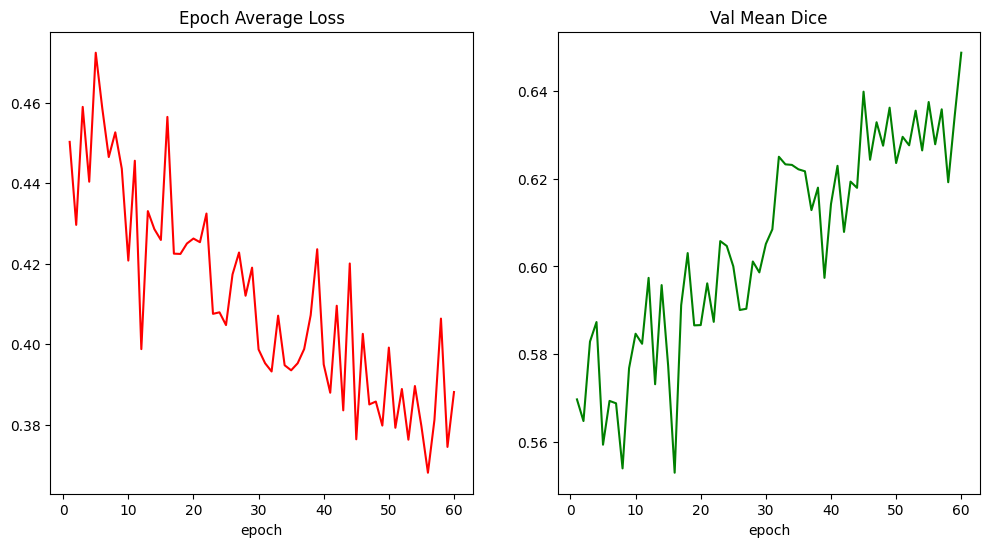

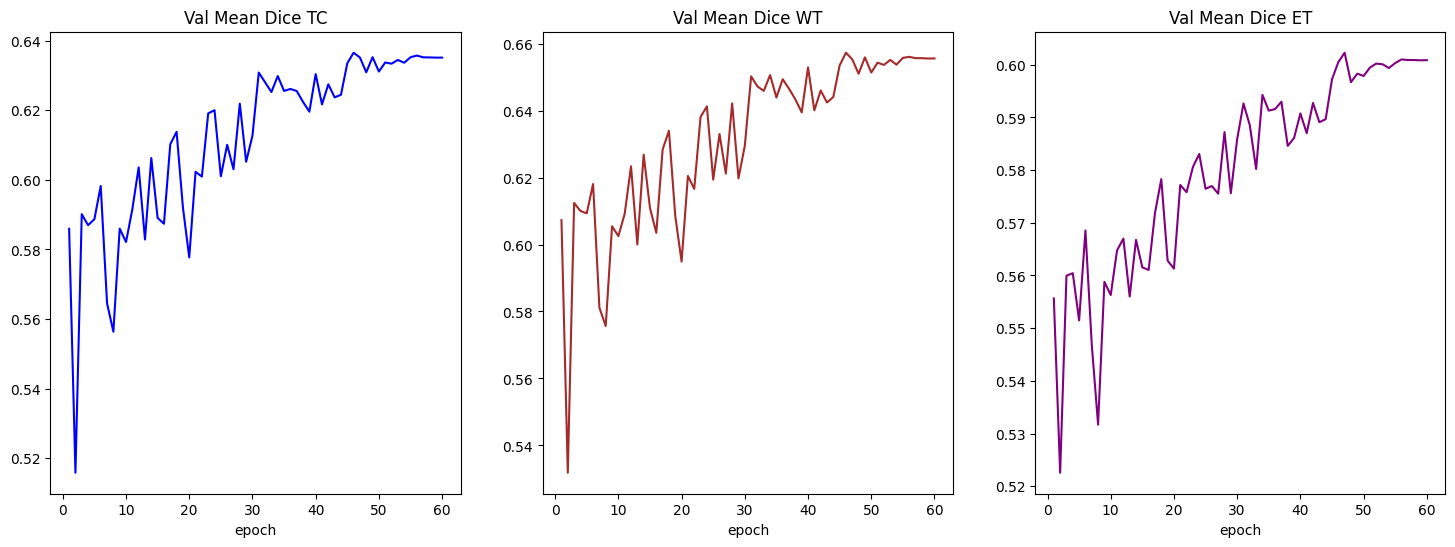

In [22]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

In [23]:
pip install nibabel

Note: you may need to restart the kernel to use updated packages.


image shape: (240, 240, 155), label shape: (240, 240, 155)


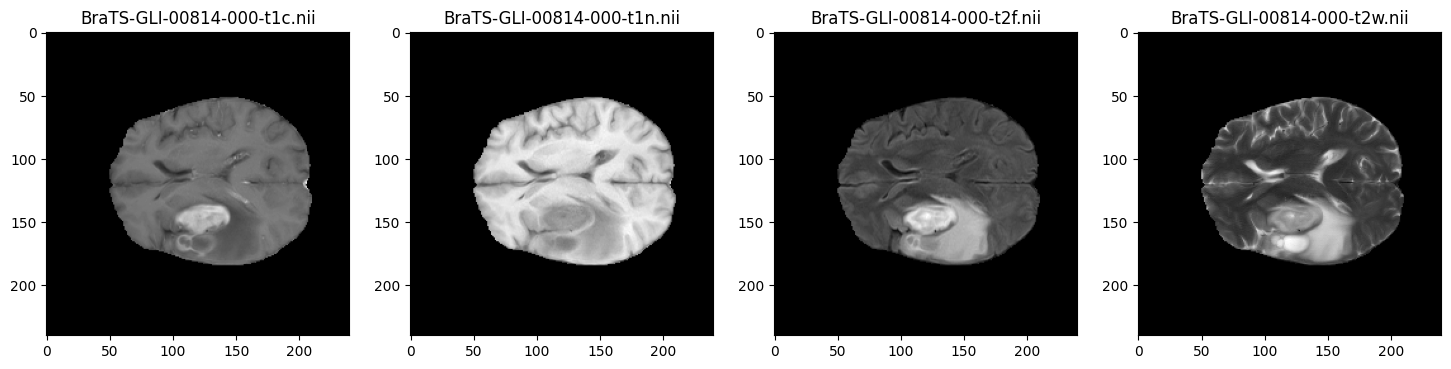

In [24]:
import nibabel as nib 
img_add = "/kaggle/input/trainingdata-brats-part2/BraTS-GLI-00814-000/BraTS-GLI-00814-000-t1c.nii"
label_add = "/kaggle/input/trainingdata-brats-part2/BraTS-GLI-00814-000/BraTS-GLI-00814-000-t1n.nii"
img_add_2 = "/kaggle/input/trainingdata-brats-part2/BraTS-GLI-00814-000/BraTS-GLI-00814-000-t2f.nii"
img_add_3 = "/kaggle/input/trainingdata-brats-part2/BraTS-GLI-00814-000/BraTS-GLI-00814-000-t2w.nii"
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
img_2 = nib.load(img_add_2).get_fdata()
img_3 = nib.load(img_add_3).get_fdata()
print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 4, 1)
plt.title("BraTS-GLI-00814-000-t1c.nii")
plt.imshow(img[:, :, 78], cmap="gray")
plt.subplot(1, 4, 2)
plt.title("BraTS-GLI-00814-000-t1n.nii")
plt.imshow(label[:, :, 78], cmap="gray")
plt.subplot(1, 4, 3)
plt.title("BraTS-GLI-00814-000-t2f.nii")
plt.imshow(img_2[:, :, 78], cmap="gray")
plt.subplot(1, 4, 4)
plt.title("BraTS-GLI-00814-000-t2w.nii")
plt.imshow(img_3[:, :, 78], cmap="gray")
plt.show()

image shape: (240, 240, 155), label shape: (240, 240, 155)


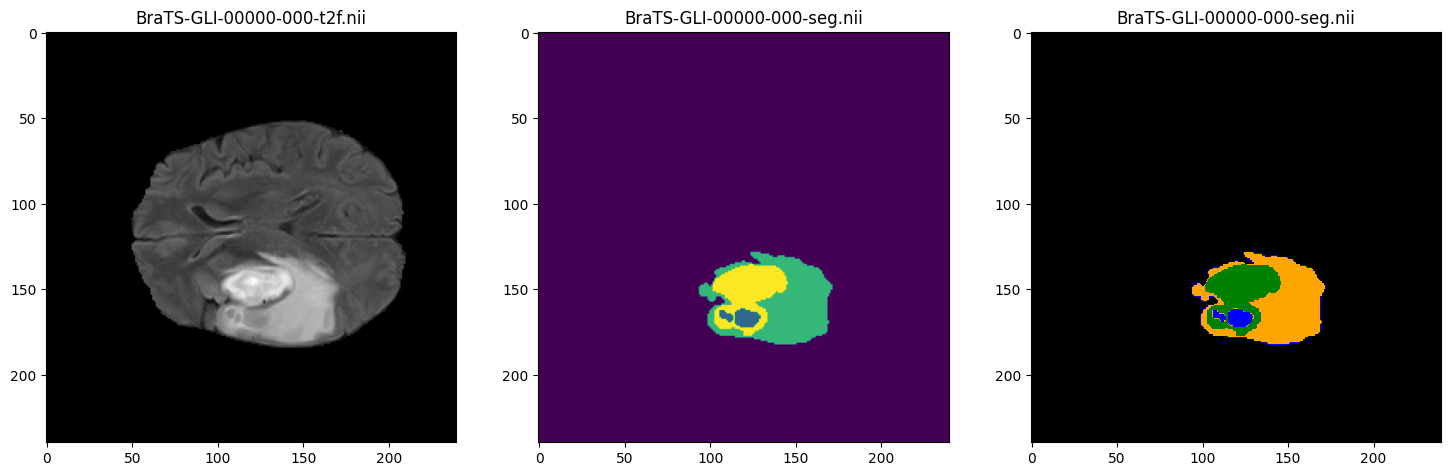

In [25]:
import nibabel as nib 
from matplotlib.colors import ListedColormap
img_add = "/kaggle/input/trainingdata-brats-part2/BraTS-GLI-00814-000/BraTS-GLI-00814-000-t2f.nii"
label_add = "/kaggle/input/trainingdata-brats-part2/BraTS-GLI-00814-000/BraTS-GLI-00814-000-seg.nii"
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
# Create a custom colormap with purple, blue, and orange colors
cmap = ListedColormap(['black', 'blue', 'orange', 'green'])

print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("BraTS-GLI-00000-000-t2f.nii")
plt.imshow(img[:, :, 78], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("BraTS-GLI-00000-000-seg.nii")
plt.imshow(label[:, :, 78])
plt.subplot(1, 3, 3)
plt.title("BraTS-GLI-00000-000-seg.nii")
plt.imshow(label[:, :, 78], cmap = cmap)
plt.show()

In [26]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_transform,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        Activationsd(keys="pred", sigmoid=True),
        AsDiscreted(keys="pred", threshold=0.5),
    ]
)

In [27]:
from monai.metrics import HausdorffDistanceMetric
from monai.metrics import SurfaceDiceMetric
from monai.metrics import MeanIoU
from monai.metrics import SurfaceDistanceMetric
from monai.metrics import ROCAUCMetric
from monai.metrics import SurfaceDiceMetric

hd_metric = HausdorffDistanceMetric(include_background=False, reduction="mean", percentile = 95)
hd_metric_batch = HausdorffDistanceMetric(include_background=True, reduction="mean_batch", percentile = 95)

sd_metric = SurfaceDistanceMetric(include_background=True, reduction="mean")
sd_metric_batch = SurfaceDistanceMetric(include_background=True, reduction="mean_batch")

meanIoU_metric = MeanIoU(include_background=True, reduction="mean")
meanIoU_metric_batch = MeanIoU(include_background=True, reduction="mean_batch")

surfaceDice_metric = SurfaceDiceMetric(include_background=True, reduction="mean", class_thresholds = (0.01, 0.01, 0.01))
surfaceDice_metric_batch = SurfaceDiceMetric(include_background=True, reduction="mean_batch", class_thresholds = (0.01, 0.01, 0.01))

model.load_state_dict(torch.load("/kaggle/input/chkpoint4new/best_metric_model (10).pth"))
model.eval()
count = 0
with torch.no_grad():
    for val_data in test_loader:
        count = count + 1
        print(count)
#         val_inputs = val_data["image"].to(device)
#         val_data["pred"] = inference(val_inputs)
#         val_data = [post_trans(i) for i in decollate_batch(val_data)]
#         val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        val_outputs = inference(val_inputs)
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)
        
        hd_metric(y_pred=val_outputs, y=val_labels)
        hd_metric_batch(y_pred=val_outputs, y=val_labels)
        
        meanIoU_metric(y_pred=val_outputs, y=val_labels)
        meanIoU_metric_batch(y_pred=val_outputs, y=val_labels)
        
        sd_metric(y_pred=val_outputs, y=val_labels)
        sd_metric_batch(y_pred=val_outputs, y=val_labels)
        
        surfaceDice_metric(y_pred=val_outputs, y=val_labels)
        surfaceDice_metric_batch(y_pred=val_outputs, y=val_labels)
        

    metric_org = dice_metric.aggregate().item()
    metric_batch_org = dice_metric_batch.aggregate()
    
    hd_metric_org = hd_metric.aggregate().item()
    hd_metric_batch_org = hd_metric_batch.aggregate()
    
    meanIoU_metric_org = meanIoU_metric.aggregate().item()
    meanIoU_metric_batch_org = meanIoU_metric_batch.aggregate()
    
    sd_metric_org = sd_metric.aggregate().item()
    sd_metric_batch_org = sd_metric_batch.aggregate()
    
    surfaceDice_metric_org = surfaceDice_metric.aggregate().item()
    surfaceDice_metric_batch_org = surfaceDice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()
    
    hd_metric.reset()
    hd_metric_batch.reset()
    
    meanIoU_metric.reset()
    meanIoU_metric_batch.reset()
    
    sd_metric.reset()
    sd_metric_batch.reset()
    
    surfaceDice_metric.reset()
    surfaceDice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch_org[0].item(), metric_batch_org[1].item(), metric_batch_org[2].item()

hd_metric_tc, hd_metric_wt, hd_metric_et = hd_metric_batch_org[0].item(), hd_metric_batch_org[1].item(), hd_metric_batch_org[2].item()

meanIoU_metric_tc, meanIoU_metric_wt, meanIoU_metric_et = meanIoU_metric_batch_org[0].item(), meanIoU_metric_batch_org[1].item(), meanIoU_metric_batch_org[2].item()

sd_metric_tc, sd_metric_wt, sd_metric_et = sd_metric_batch_org[0].item(), sd_metric_batch_org[1].item(), sd_metric_batch_org[2].item()

surfaceDice_metric_tc, surfaceDice_metric_wt, surfaceDice_metric_et = surfaceDice_metric_batch_org[0].item(), surfaceDice_metric_batch_org[1].item(), surfaceDice_metric_batch_org[2].item()

print("Metric on original image spacing: ", metric_org)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")

print("HD Metric on original image spacing: ", hd_metric_org)
print(f"HD metric_tc: {hd_metric_tc:.4f}")
print(f"HD metric_wt: {hd_metric_wt:.4f}")
print(f"HD metric_et: {hd_metric_et:.4f}")

print("MeanIoU Metric on original image spacing: ", meanIoU_metric_org)
print(f"MeanIoU metric_tc: {meanIoU_metric_tc:.4f}")
print(f"MeanIoU metric_wt: {meanIoU_metric_wt:.4f}")
print(f"MeanIoU metric_et: {meanIoU_metric_et:.4f}")

print("SD Metric on original image spacing: ", sd_metric_org)
print(f"SD metric_tc: {sd_metric_tc:.4f}")
print(f"SD metric_wt: {sd_metric_wt:.4f}")
print(f"SD metric_et: {sd_metric_et:.4f}")

print("Surface Dice Metric on original image spacing: ", surfaceDice_metric_org)
print(f"Surface Dice metric_tc: {surfaceDice_metric_tc:.4f}")
print(f"Surface Dice metric_wt: {surfaceDice_metric_wt:.4f}")
print(f"Surface Dice metric_et: {surfaceDice_metric_et:.4f}")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/chkpoint4new/best_metric_model (10).pth'

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_transform,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        Activationsd(keys="pred", sigmoid=True),
        AsDiscreted(keys="pred", threshold=0.5),
    ]
)

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)